In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Batch sizes
batch_sizes = np.array([120, 160, 200, 240])

# Probabilities from Table 2 (rows = years, cols = batch sizes)
probabilities = np.array([
    [0.25, 0.25, 0.25, 0.25],  # Year 1
    [0.30, 0.25, 0.25, 0.20],  # Year 2
    [0.30, 0.30, 0.20, 0.20],  # Year 3
    [0.35, 0.30, 0.20, 0.15],  # Year 4
    [0.40, 0.30, 0.20, 0.10],  # Year 5
])

cost_per_unit = 2      # € per bumper per day
days_per_year = 365

# Oven capacities
capacities = {
    "Oven 1": 180,
    "Oven 2": 200,
    "Oven 3": 220
}

# -----------------------------
# Function to compute storage cost
# -----------------------------

def storage_cost_per_year(capacity):
    """
    Returns a list with annual storage cost for each of the 5 years
    """
    annual_costs = []
    
    for year_probs in probabilities:
        # overflow units for each batch size
        overflow = np.maximum(0, batch_sizes - capacity)
        
        # expected daily storage cost
        expected_daily_cost = np.sum(
            year_probs * overflow * cost_per_unit
        )
        
        # annual cost
        annual_costs.append(expected_daily_cost * days_per_year)
        
    return annual_costs


# -----------------------------
# Calculate results
# -----------------------------

results = []

for oven, cap in capacities.items():
    yearly_costs = storage_cost_per_year(cap)
    avg_cost = np.mean(yearly_costs)
    
    results.append([oven, *yearly_costs, avg_cost])

columns = [
    "Oven",
    "Year 1 (€)", "Year 2 (€)", "Year 3 (€)",
    "Year 4 (€)", "Year 5 (€)",
    "5-year average (€)"
]

df = pd.DataFrame(results, columns=columns)

print(df.round(0))

     Oven  Year 1 (€)  Year 2 (€)  Year 3 (€)  Year 4 (€)  Year 5 (€)  \
0  Oven 1     14600.0     12410.0     11680.0      9490.0      7300.0   
1  Oven 2      7300.0      5840.0      5840.0      4380.0      2920.0   
2  Oven 3      3650.0      2920.0      2920.0      2190.0      1460.0   

   5-year average (€)  
0             11096.0  
1              5256.0  
2              2628.0  


In [13]:
np.random.seed(42)

N_SIM = 10000
DISCOUNT_RATE = 0.05
DF = sum(1 / (1 + DISCOUNT_RATE) ** t for t in range(1, 6))

In [14]:
# Energy prices
gas_price = np.random.normal(1.30, 0.20, N_SIM)
elec_price = np.random.normal(1.80, 0.30, N_SIM)

# Failure repair cost
repair_cost = np.random.normal(5000, 2500, N_SIM)

# Subsidy for Oven 3 (Bernoulli)
subsidy = np.random.binomial(1, 0.10, N_SIM) * 50000

In [15]:
def simulate_npv(investment, annual_cf):
    return -investment + annual_cf * DF

In [16]:
cf_oven1 = np.random.normal(49475, 8000, N_SIM)
cf_oven2 = np.random.normal(62057, 10000, N_SIM)
cf_oven3 = np.random.normal(79280, 12000, N_SIM)

In [17]:
npv_oven1 = simulate_npv(160000, cf_oven1)
npv_oven2 = simulate_npv(240000, cf_oven2)
npv_oven3 = simulate_npv(330000 - subsidy, cf_oven3)

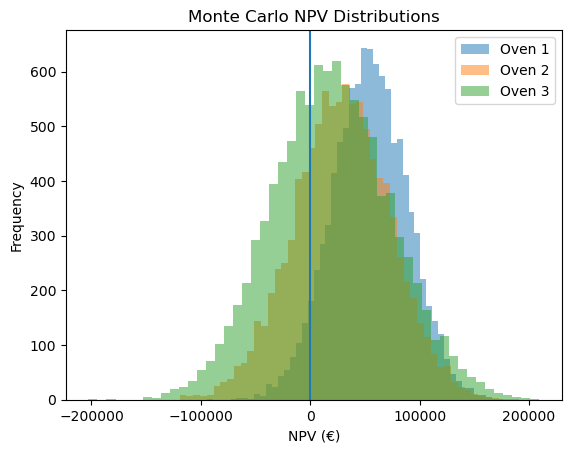

In [21]:
plt.hist(npv_oven1, bins=50, alpha=0.5, label='Oven 1')
plt.hist(npv_oven2, bins=50, alpha=0.5, label='Oven 2')
plt.hist(npv_oven3, bins=50, alpha=0.5, label='Oven 3')

plt.axvline(0)
plt.legend()
plt.title("Monte Carlo NPV Distributions")
plt.xlabel("NPV (€)")
plt.ylabel("Frequency")
plt.show()

In [19]:
results = pd.DataFrame({
    "Mean NPV": [np.mean(npv_oven1), np.mean(npv_oven2), np.mean(npv_oven3)],
    "P(NPV < 0)": [
        np.mean(npv_oven1 < 0),
        np.mean(npv_oven2 < 0),
        np.mean(npv_oven3 < 0)
    ]
}, index=["Oven 1", "Oven 2", "Oven 3"])

print(results)

            Mean NPV  P(NPV < 0)
Oven 1  54472.207530      0.0569
Oven 2  28588.194163      0.2545
Oven 3  19312.256107      0.3665


In [20]:
def sensitivity(base_cf, factor):
    return np.mean(simulate_npv(240000, base_cf * factor))

factors = [0.8, 1.0, 1.2]
sens_results = [sensitivity(cf_oven2, f) for f in factors]

sens_results

[-25129.4446697485, 28588.19416281436, 82305.83299537722]